Jorge Gutierrez (026868970)

05/15/24

# Run the Code Below to Import Animal Dataset

In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animals10:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F59760%2F840806%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T110330Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D231b1fb439523d4ba98b7f276b7be82a79b611ccc52eff837f51c633a576e812c28780c2c1a17b2643c10e7a5cf4304bae904679dc5e67a4d774bdd00fe99ed9f61dbf3ce9b8089887df6ba34e492dbf94c0b8d6d6997675cfe5aa688a6b23d86ca5e7cec698acf345976ccf087040c360140dc4d07f07b403a59e431f552b4d16bb6ac74e1732be83d476e6bd890a1d68fe90341cef0e0214d6c468351be2889d465e9f0d5457644921a508a7872fffd709f312c9333f3b95f250043c9e7108bc18b72276642db6a789b8ff71778e42e709232bb75e5647c6eb690535fa8ad59dae858be87ee5b156fb83b02790b4b92ecd4b74fd679997a8b660428f33ebc0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 614087302 bytes downloaded
Downloaded and uncompressed: animals10
Data source import complete.


# Importing the Libraries

In [5]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pathlib
from tensorflow import keras

# Importing the Dataset

In [18]:
# Add the dataset folder into the data_dir variable to be able to access the dataset within the code when needed
data_dir = '/kaggle/input/animals10/raw-img'
data_dir = pathlib.Path(data_dir).with_suffix('')

# Geting the number of samples in each class (number of images per class)
class_names = sorted(os.listdir(data_dir))
class_sizes = []
for name in class_names:
    class_size = len(os.listdir("/kaggle/input/animals10/raw-img/" + name))
    class_sizes.append(class_size)
# Printing the class distribution
print("Class Name and Distribution:\n", class_sizes)

# Translating the class names to English
for i in range(len(class_names)):
  if class_names[i] == 'cane':
    class_names[i] = 'dog'
  elif class_names[i] == 'cavallo':
    class_names[i] = 'horse'
  elif class_names[i] == 'elefante':
    class_names[i] = 'elephant'
  elif class_names[i] == 'farfalla':
    class_names[i] = 'butterfly'
  elif class_names[i] == 'gallina':
    class_names[i] = 'chicken'
  elif class_names[i] == 'gatto':
    class_names[i] = 'cat'
  elif class_names[i] == 'mucca':
    class_names[i] = 'cow'
  elif class_names[i] == 'pecora':
    class_names[i] = 'sheep'
  elif class_names[i] == 'ragno':
    class_names[i] = 'spider'
  elif class_names[i] == 'scoiattolo':
    class_names[i] = 'squirrel'

print(class_names)
print()

# initialize the image height, width, batch size, and epochs which will be used later to train the model
img_height = 250
img_width = 250
batch_size = 64
epochs = 10

Class Name and Distribution:
 [4863, 2623, 1446, 2112, 3098, 1668, 1866, 1820, 4821, 1862]
['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']



# Splitting the Dataset Into the Training Set and Validation Set

In [8]:
# split the dataset into a training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset='training',
    seed = 123,
    image_size= (img_height,img_width),
    batch_size=batch_size
)

print()

# split the dataset into a validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    seed=123,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size = batch_size
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.

Found 26179 files belonging to 10 classes.
Using 7853 files for validation.


# Data Standardization

In [9]:
# Create a normalization layer to standardize the dataset, ensuring a consistent distribution, preventing a skewed dataset
normalization_layer = layers.Rescaling(1./255)
normalized_ds  = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


# Data Augumentation Layer

In [13]:
# Create a data augumentation layer to modify the existing data to create more data
# i.e. rotate an image or zomm into an image
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Building a Neural Network Model

In [25]:
# Create a neural network model we will be training
num_of_classes = len(train_ds.class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_of_classes, name="outputs")
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 125, 125, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                

# Compiling the Model

In [27]:
# Compile the model we created with adam as the optimizer, sparse categorical crossentropy, and accuracy as the metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

# Training Neural Network Model

In [28]:
# Train the model over 10 epochs
history = model.fit(train_ds,validation_data=val_ds, epochs=epochs)

Epoch 1/10
328/328 [==============================] - 57s 164ms/step - loss: 1.8819 - accuracy: 0.3462 - val_loss: 1.6558 - val_accuracy: 0.4522
Epoch 2/10
328/328 [==============================] - 65s 195ms/step - loss: 1.5162 - accuracy: 0.4815 - val_loss: 1.4185 - val_accuracy: 0.5264
Epoch 3/10
328/328 [==============================] - 58s 173ms/step - loss: 1.3589 - accuracy: 0.5431 - val_loss: 1.2808 - val_accuracy: 0.5690
Epoch 4/10
328/328 [==============================] - 56s 167ms/step - loss: 1.2379 - accuracy: 0.5816 - val_loss: 1.2387 - val_accuracy: 0.5879
Epoch 5/10
328/328 [==============================] - 61s 185ms/step - loss: 1.1750 - accuracy: 0.6061 - val_loss: 1.2072 - val_accuracy: 0.6010
Epoch 6/10
328/328 [==============================] - 65s 197ms/step - loss: 1.1159 - accuracy: 0.6242 - val_loss: 1.2091 - val_accuracy: 0.5968
Epoch 7/10
328/328 [==============================] - 59s 178ms/step - loss: 1.0709 - accuracy: 0.6379 - val_loss: 1.0713 - val_ac

# Evaluation

In [36]:
# Print out the results of the accuracy and loss for both the training and validation sets
print("Training Accuracy: ", history.history['accuracy'])
print("Validation Accuracy: ", history.history['val_accuracy'])
print()
print("Training Loss: ", history.history['loss'])
print("Validation Loss: ", history.history['val_loss'])

Training Accuracy:  [0.3461611866950989, 0.4814743995666504, 0.543114960193634, 0.5816463232040405, 0.6060924530029297, 0.6241883039474487, 0.6379392743110657, 0.6477272510528564, 0.6634835600852966, 0.6676375269889832]
Validation Accuracy:  [0.45218387246131897, 0.5264230370521545, 0.5689545273780823, 0.5879281759262085, 0.6010441780090332, 0.5968419909477234, 0.6448491215705872, 0.6443397402763367, 0.6566917300224304, 0.667006254196167]

Training Loss:  [1.881915807723999, 1.5161875486373901, 1.358923316001892, 1.2379242181777954, 1.1750208139419556, 1.1158827543258667, 1.0709092617034912, 1.0417250394821167, 0.9976223707199097, 0.9853026866912842]
Validation Loss:  [1.6558113098144531, 1.4184718132019043, 1.2807940244674683, 1.2386821508407593, 1.2072473764419556, 1.2090978622436523, 1.0712834596633911, 1.0638482570648193, 1.0253384113311768, 0.9911174774169922]


# Predicting Images

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 22ms/step


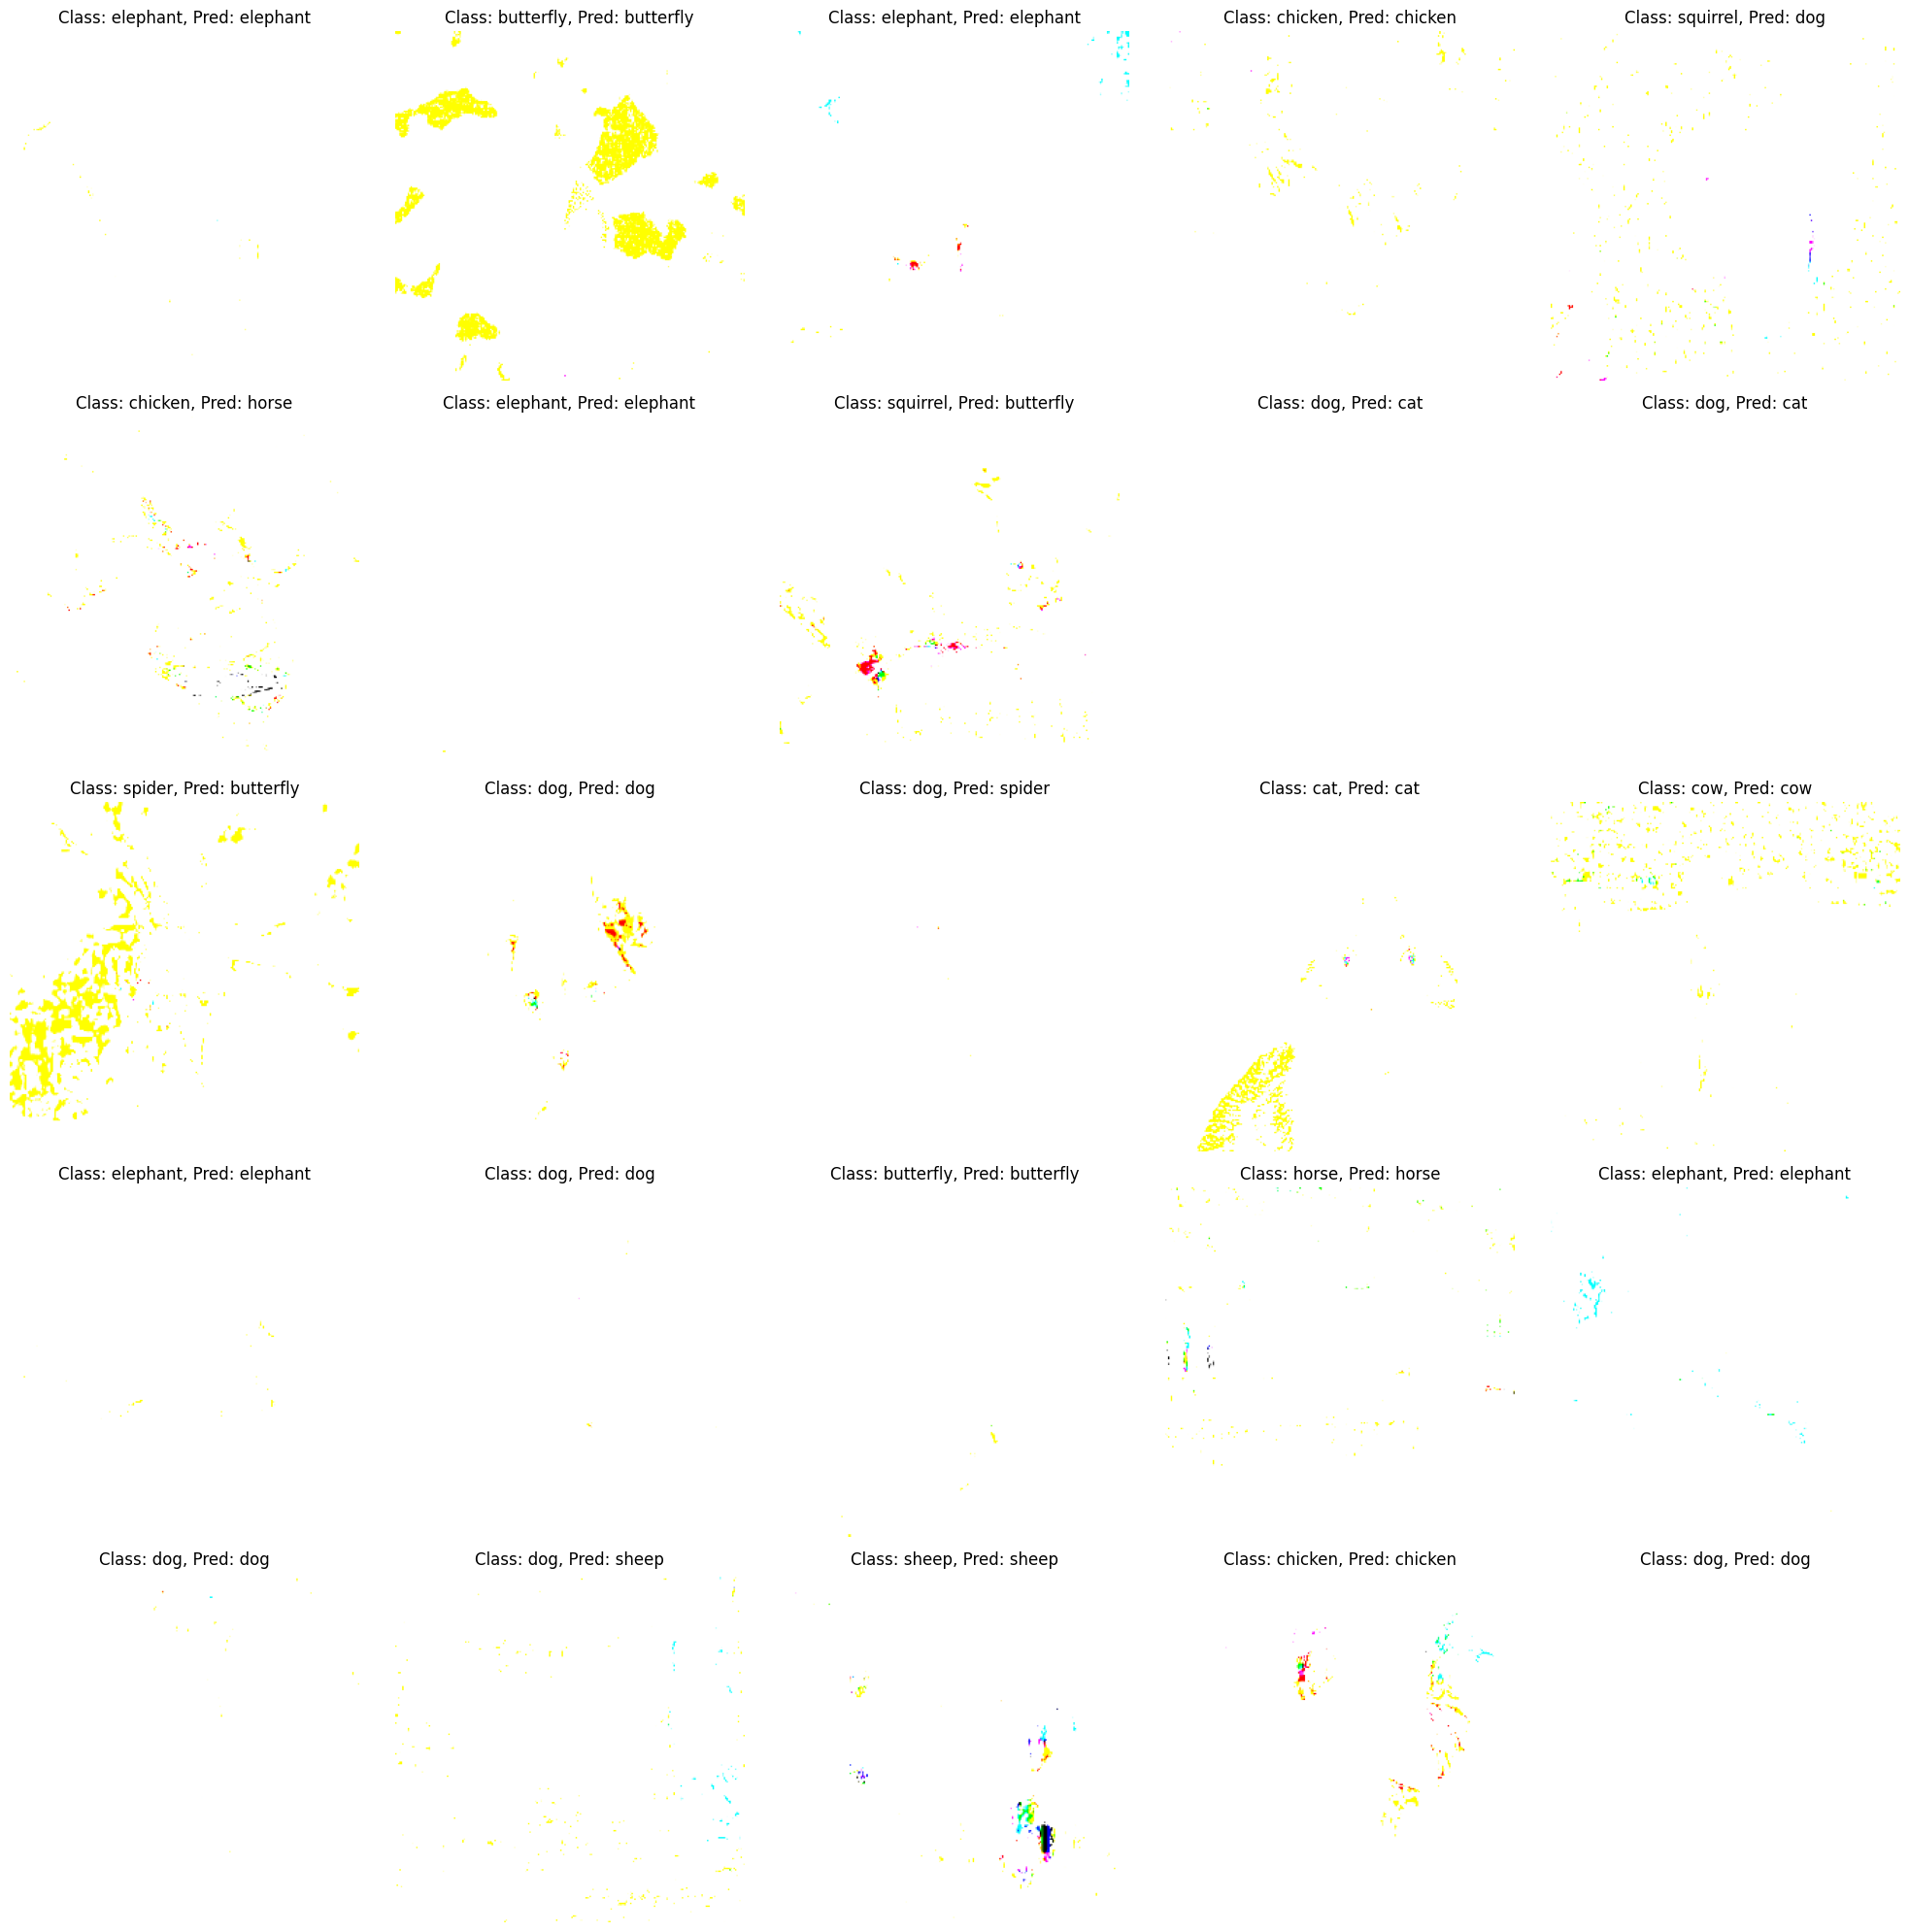

In [57]:
# This function takes in an image and an optional title and plots the image.
def show_image(image, image_title=None):
    # Display the image
    plt.imshow(image)
    # Set the title of the plot if provided
    plt.title(image_title)
    # Turn off the axes in the plot
    plt.axis('off')

# Function to get a random image from the dataset
def get_random_data(data_tuple):
    images, labels = data_tuple
    # geting a random index for an image in the dataset
    idx = np.random.randint(len(images))
    # selecting the image and its corresponding label using the random index
    image, label = images[idx], labels[idx]
    # returning the selected image and label
    return image, label

# Plot the images with their expected and predicted outputs
plt.figure(figsize=(20,20))
i=1
for images, labels in iter(val_ds):
    # Get Random Image and label
    image, label = get_random_data([images, labels])
    pred_label = class_names[np.argmax(model.predict(image[np.newaxis,...]))]
    # Plot it
    plt.subplot(5,5,i)
    show_image(image)  # Call show_image without the title parameter
    plt.title(f"Class: {class_names[int(label)]}, Pred: {pred_label}")  # Set the title using plt.title
    # Make sure to end the loop
    i += 1
    if i >= 26:
        break
plt.tight_layout()
plt.show()